# Control Systems 1, NB11:  Time delays and Cascaded Control

© 2024 ETH Zurich, Mark Benazet Castells, Jonas Holinger, Felix Muller, Matteo Penlington; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

This interactive notebook is designed to introduce the fundamental concepts of control systems engineering. It covers time delays, how to approximate them, and their influence on system performance. Additionally, the notebook provides a brief overview of cascaded control.

Authors:
- Jonas Holinger; jholinger@ethz.ch
- Shubham Gupta; shugupta@ethz.ch

# Learning Objectives


After completing this notebook, you should be able to:

1. Understand the effects of time delays on frequency response.
2. Approximate time delays as a proper rational transfer function.
3. Apply the root locus with time delays, and understand its influence on system stability.
4. Grasp the fundamentals of cascaded control.

Note that the following concepts from the lecture are not covered in this notebook:
- How to implement a compensator.
- Recap of the Euler approximation.
- How to select a sampling time to deal with non-proper transfer functions.
- Recap of non-linear systems and the linearization procedure.

## Import Libraries

In [7]:
%pip install numpy matplotlib scipy ipywidgets control IPython sympy

#@title Import Libraries

import control as ct
import matplotlib.pyplot as plt
import numpy as np
import math
import ipywidgets as widgets
from scipy.integrate import odeint
from IPython.display import display, clear_output, Math
from ipywidgets import interactive, FloatSlider, VBox, ToggleButton, FloatSlider
from scipy import signal
import warnings
warnings.filterwarnings("ignore")


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Motivation

So far in the course we have analyzed ideal models, i.e., models that are linear and time-invariant (LTI). However, most *real* systems deviate from these idealizations. As a result, it becomes crucial to understand and account for these phenomena. Two such phenomena are time delays and nonlinearities. In this notebook time delays are introduced, along with their effects, and how they can be adapted (approximated) to use the tools that have been previously introduced (e.g,. Root locus). Nonlinearities will be introduced in the following week.

Furthermore, typically, systems consist of a system of systems. Consider that adaptive cruise control aims to control the position of the vehicle with respect to the vehicle in front. As a consequence, it must determine a) the desired speed of the vehicle to maintain the distance, and then correspondingly control the throttle to achieve the appropriate speed. This form of system architecture is referred to as cascaded control, and is touched upon in this notebook.

# 1. Time Delays


A time delay refers to the phenomenon where there is a delay between the input to the system and its corresponding output response. This delay can occur due to various reasons, such as sensor response time, communication latency in a controller implemented within a computer, or physical delays, like water traveling inside a pipe when the shower is turned on.

Time delays can (negatively) influence system performance, and even introduce instabilities. This can be explained intuitively, by considering that in a closed-loop, the input to the controller is the error between a reference and output. If the time delay is not considered, the produced output may be different from what was expected (i.e., delayed). Thus, the tuned controller may be functioning out-of-sync, and hence exhibiting unstable output behavior.

Consequentially, we want to account for the effects of time delays. The time delay operator, which transforms an input signal $ u(t) $ into a delayed output $ y(t) = u(t-T) $ with a delay of $ T $ seconds, is represented in the Laplace domain as:
$$e^{-sT}$$

The time delay operator is a linear operator, but the resulting transfer function is not rational, which means we cannot apply the root-locus method. To see why this is the case, consider that the root locus relies on the characteristic equation $1+kL(s)=0$ to define the closed-loop poles. However, in the case where we have a non-rational transfer function, e.g., $e^{-sT}$, then no poles exist for $k>0$.

Below we provide a brief example to contextualize how accounting for a time-delay may result in a non-rational transfer function.

### Example

Suppose we have a first-order system of the form $ G(s) = \frac{5}{s+3} $, and through experiments have determined that a time delay of 4 seconds is present. It is then possible to account for the time delay by defining the new transfer function, $\tilde{G}(s)$ as:
$$\tilde{G}(s) = \frac{5}{s+3}e^{-4s}$$

### Visualization

Below we plot the step response of a 2nd order system with a time delay $\tilde{G}(s) = \frac{\omega_n^2}{s^2+2\zeta\omega_n s + \omega_n^2}e^{-sT}$.

Try varying the time delay, how does the output vary? Is this was you expected?

In [8]:
def plot_step_response_delay(wn, zeta, delay):

    num = [wn**2]
    den = [1, 2*zeta*wn, wn**2]
    sys = ct.TransferFunction(num, den)

    delay_approx = ct.pade(delay, 5)
    delay_tf = ct.TransferFunction(*delay_approx)
    sys_delayed = sys * delay_tf

    time = np.linspace(0, 20, 500)

    t, y_no_delay = ct.step_response(sys, T=time)  # Without delay
    t, y_with_delay = ct.step_response(sys_delayed, T=time)  # With delay

    plt.figure(figsize=(10, 6))
    plt.plot(t, y_no_delay, label=f'No Delay')
    plt.plot(t, y_with_delay, label=f'With Delay={delay}s', linestyle='--')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title('Second Order System Step Response with and without Time Delay')
    plt.grid(True)
    plt.legend()
    plt.show()

wn_slider = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='ωn')
zeta_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description='ζ')
delay_slider = widgets.FloatSlider(value=0.0, min=0.0, max=2.0, step=0.01, description='Delay')

interactive_plot = widgets.interactive(plot_step_response_delay, wn=wn_slider, zeta=zeta_slider, delay=delay_slider)
display(interactive_plot)


interactive(children=(FloatSlider(value=1.0, description='ωn', max=5.0, min=0.1), FloatSlider(value=0.5, descr…

## 1.1 Time Delay in Frequency Response


Above we saw how the time delay influences the time-domain output response (a temporal shift in the output). However, since time delays may also influence the systems capabilities to accurately track commands or reject disturbances, it is also useful to understand its influence on the frequency response.  

> First, note that the magnitude of the time delay is $ \left| e^{-j\omega T} \right| = 1 $ and the phase is $ \angle(e^{-j\omega T}) = -\omega T $. Thus, it is important to note that the time delay only influences the phase in the frequency domain.

To see why the above is the case:
- $ \left| e^{-j\omega T} \right| = 1 $: $e^{-j\omega T} = \cos{\omega T} - j \sin{\omega T}$. Then the magnitude is described by: $| e^{-j\omega T} | = \sqrt{\cos^2{\omega T} + \sin^2{\omega T}} = 1$.
- $ \angle(e^{-j\omega T}) = -\omega T $: $\angle{e^{-j\omega T}} = \arctan{\frac{-\sin{\omega T}}{\cos{\omega T}}} = -\omega T$.



For the open-loop Transfer function, $\tilde{L}(s)=e^{-sT}L(s)$, this means:
$$\left| \tilde{L}(jw) \right|=\left|L(jw) \right|$$

$$\angle \tilde{L}(jw)=\angle L(jw)-wT$$

Thus, the time delay:
- Rotates the polar plot clockwise by $\omega T$.
- Changes the phase margin of the system such that:
$$ \phi_{m,t} = \phi_{0} - \omega_c T $$
Where:
-  $\phi_{m,t}$ is the new phase margin after the time delay.
-  $\phi_{0}$ is the phase margin without a time delay.
-  $\omega_c$ is the crossover frequency (does not depend on time delay).

Hence:
> Time delays reduce the phase margins.




### Effect on the Bode plot

Below we plot the transfer function $\tilde{L}(s) = \frac{N(s)}{G(s)}e^{-sT}$ in blue, and in orange the time delay Bode plot.
- Note that due to python support limitations, we have to approximate the time delay as a high-order rational transfer function. Later on we introduce how to do this.

Try adjusting the time delay and observe how the margins change.
Are you able to find a time delay that makes the system unstable? And one for which the system is stable?

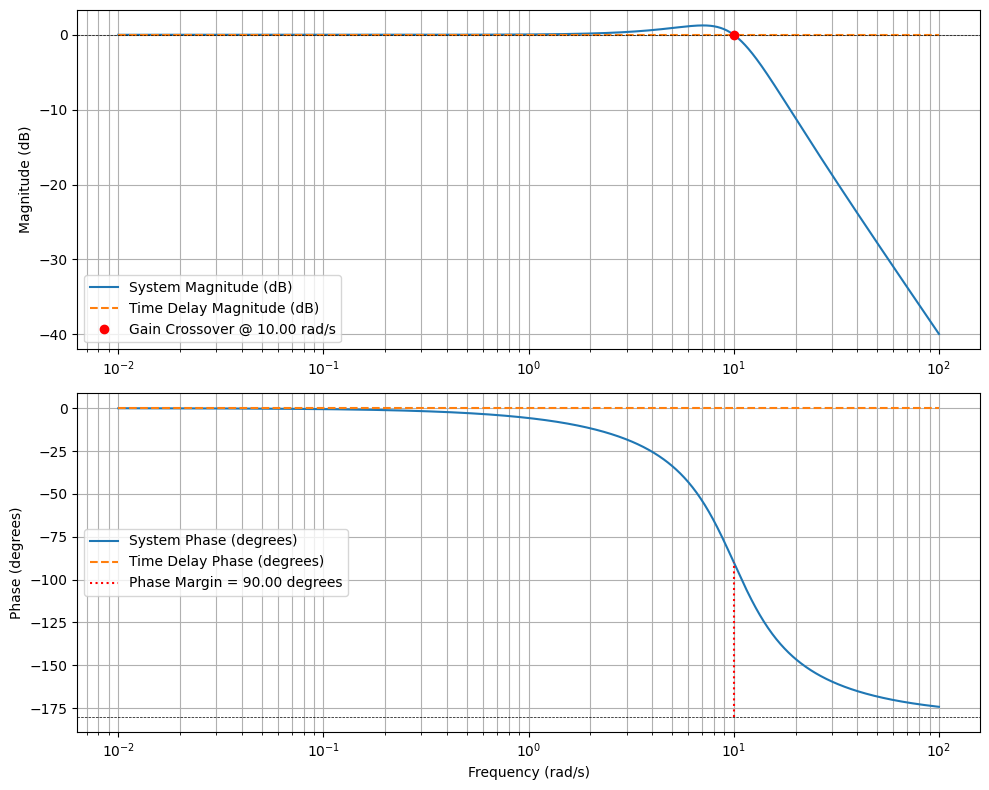

In [9]:
def bode_plot_with_margins_delay(num, den, delay_num=None, delay_den=None):
    if delay_num is not None and delay_den is not None:
        delay_sys = ct.TransferFunction(delay_num, delay_den)
        sys = ct.series(ct.TransferFunction(num, den), delay_sys)
    else:
        sys = ct.TransferFunction(num, den)

    gm, pm, wcg, wcp = ct.margin(sys)

    w = np.logspace(-2, 2, 1000)

    if delay_num is not None and delay_den is not None:
        mag_d, phase_d, omega_d = ct.bode_plot(delay_sys,omega=w, dB=True, deg=True, plot=False)
        mag_d = 20 * np.log10(mag_d)
        phase_d = np.degrees(phase_d)
        phase_d = phase_d%(-360)
    else:
        mag_d, phase_d, omega_d = None, None, None

    mag, phase, omega = ct.bode_plot(sys, omega=w, dB=True, deg=True, plot=False)
    mag = 20 * np.log10(mag)
    phase = np.degrees(phase)
    phase = phase%(-360)

    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.semilogx(omega, mag, label='System Magnitude (dB)')
    if mag_d is not None:
        plt.semilogx(omega_d, mag_d, label='Time Delay Magnitude (dB)', linestyle='--')

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

    if not np.isnan(wcp):
        plt.plot(wcp, 0, 'ro', label=f'Gain Crossover @ {wcp:.2f} rad/s')
    if gm != float('inf'):
        plt.vlines(wcg, 0, -20 * np.log10(gm), color='red', linestyle=':', label=f'Gain Margin = {20 * np.log10(gm):.2f} dB')

    plt.ylabel('Magnitude (dB)')
    plt.legend(loc='best')
    plt.grid(True, which="both")

    plt.subplot(2, 1, 2)
    plt.semilogx(omega, phase, label='System Phase (degrees)')
    if phase_d is not None:
        plt.semilogx(omega_d, phase_d, label='Time Delay Phase (degrees)', linestyle='--')

    plt.axhline(-180, color='black', linewidth=0.5, linestyle='--')

    if not np.isnan(wcg):
        plt.plot(wcg, -180, 'bo', label=f'Phase Crossover @ {wcg:.2f} rad/s')
    if pm != float('inf'):
        plt.vlines(wcp, -180, -180 + pm, color='red', linestyle=':', label=f'Phase Margin = {pm:.2f} degrees')

    plt.ylabel('Phase (degrees)')
    plt.xlabel('Frequency (rad/s)')
    plt.legend(loc='best')
    plt.grid(True, which="both")

    plt.tight_layout()
    plt.show()

def update_bode_plot(b):
    clear_output(wait=True)
    display(widgets.VBox([numerator_text, denominator_text, delay_slider, plot_button]))

    try:
        num = [float(x) for x in numerator_text.value.split(',')]
        den = [float(x) for x in denominator_text.value.split(',')]
        delay = delay_slider.value

        delay_num, delay_den = ct.pade(delay, n=10)
        bode_plot_with_margins_delay(num, den, delay_num, delay_den)
    except ValueError:
        print("Please enter valid coefficients separated by commas.")

numerator_text = widgets.Text(value='100', description='Numerator:', placeholder='e.g., 10,4')
denominator_text = widgets.Text(value='1,10,100', description='Denominator:', placeholder='e.g., 12,30,50')

delay_slider = widgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=2.0,
    step=0.01,
    description='Time Delay (s):',
    continuous_update=False
)

plot_button = widgets.Button(description="Plot Bode")
plot_button.on_click(update_bode_plot)

display(widgets.VBox([numerator_text, denominator_text, delay_slider, plot_button]))


### Effect on the Nyquist Plot



The Nyquist plot of a time delay operator is simply a unit circle.

To verify this, consider a transfer function, $L(s)=1\cdot e^{-sT}$.

Thus, for any system, the time delay introduces a counterclockwise rotation of the Nyquist plot. This rotation becomes more pronounced as the frequency increases. As the delay increases, the system's Nyquist plot may begin to encircle the critical point $\left(\frac{-1}{k},0\right)$, potentially leading to instability.

First try to verify that the time delay Nyquist is indeed a unit circle. 
Then, investigate the effect of increasing the time delay for any system. What does the resulting Nyquist look like?

Below we consider the system with a unity controller, i.e., $k=1$.

In [10]:


def parse_coefficients(coeff_str):
    """
    Parse a string of coefficients separated by commas into a list of floats.
    """
    try:
        coeffs = [float(c.strip()) for c in coeff_str.split(',') if c.strip()]
        if not coeffs:
            raise ValueError("Coefficient list cannot be empty.")
        return coeffs
    except ValueError as e:
        raise ValueError(f"Invalid input: {e}")

def transfer_function_with_delay(num, den, delay):

    G = ct.TransferFunction(num, den)
    delay_num, delay_den = ct.pade(delay, n=10)
    G_delay = ct.TransferFunction(delay_num, delay_den)
    return G * G_delay

def plot_nyquist_and_poles(num, den, delay):
    """
    Generate a single Nyquist plot showing the system with and without time delay and display system poles.
    """
    with output:
        clear_output(wait=True)
        try:
            # Create transfer functions
            G = ct.TransferFunction(num, den)
            G_delay = transfer_function_with_delay(num, den, delay)

            # Create a single plot
            plt.figure(figsize=(10, 6))

            # Nyquist plot with delay
            ct.nyquist_plot(G_delay, label=f"With Time Delay = {delay} s", color='blue')

            # Nyquist plot without delay
            ct.nyquist_plot(G, label="Without Time Delay", color='orange')

            plt.title("Nyquist Plot with and without Time Delay")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


        except ValueError as ve:
            display(ve)
        except Exception as e:
            display(e)


numerator_input = widgets.Text(
    value='1, 1',
    placeholder='Enter coefficients separated by commas',
    description='Numerator:',
    disabled=False
)

denominator_input = widgets.Text(
    value='1, 2, 1',
    placeholder='Enter coefficients separated by commas',
    description='Denominator:',
    disabled=False
)

time_delay_slider = widgets.FloatSlider(
    value=0.1,
    min=0.0,
    max=5.0,
    step=0.01,
    description='Time Delay (s):',
    continuous_update=False
)

generate_button = widgets.Button(
    description='Generate Nyquist Plots',
    button_style='success',
    tooltip='Click to generate Nyquist plots for the system',
)

# Output area
output = widgets.Output()

# Event handler for button click
def on_button_click(b):
    try:
        num = parse_coefficients(numerator_input.value)
        den = parse_coefficients(denominator_input.value)
        delay = time_delay_slider.value
        plot_nyquist_and_poles(num, den, delay)
    except ValueError as e:
        with output:
            clear_output(wait=True)
            display(e)

generate_button.on_click(on_button_click)

# Display widgets
display(numerator_input, denominator_input, time_delay_slider, generate_button, output)


Text(value='1, 1', description='Numerator:', placeholder='Enter coefficients separated by commas')

Text(value='1, 2, 1', description='Denominator:', placeholder='Enter coefficients separated by commas')

FloatSlider(value=0.1, continuous_update=False, description='Time Delay (s):', max=5.0, step=0.01)

Button(button_style='success', description='Generate Nyquist Plots', style=ButtonStyle(), tooltip='Click to ge…

Output()

## 1.2 Approximation of Time Delays


Since the transfer function of a time delay $e^{-sT}$ is not rational, it is not possible to use the root locus method (and depending on the software, non-rational transfer functions may not be supported). Thus, there is a need to approximate the time delay. Below we introduce 2 approaches to doing so.



### 1.2.1 Taylor Approximation


One approach is to approximate the time delay through a $n^{th}$ order Taylor series expansion:
$$
e^{-sT} \approx 1 - sT + \frac{1}{2}\left(sT\right)^2 + \dots + (-1)^n \frac{1}{n!}\left(sT\right)^n
$$

For example, a Taylor series expansion with $n=3$ would be:
$$e^{-sT}\approx 1-sT+\frac{1}{2}(sT)^2-\frac{1}{6}(sT)^3 = \frac{-\left(sT\right)^3 +3(sT)^2 -6(sT)+ 6}{6}$$
We can see that the above is a non-proper rational transfer function since the numerator polynomial has a higher degree than the denominator. Thus, when $|sT|>1$, the non-proper transfer function grows without bound, which implies infinite gain at high frequencies -- which is not true as $|e^{-j\omega T}|=1, \forall \omega$.

This makes the Taylor series expansion an unsuitable approximation unless $|sT|<<1$.


### 1.2.2 Padé Approximation


Another approach, is to approximate the time delay as a ratio of polynomials. For calculating the Padé approximant by hand, we limit ourselves to the first-order Padé approximation, which consists of the ratio of two first-order polynomials:
$$e^{-sT} \approx k\frac{s+p}{s+q}$$

For finding the coefficients $k$, $p$, and $q$, set the approximation equal to the Taylor series expansion:
$$k\frac{s+p}{s+q} = 1 - sT + \frac{1}{2}(sT)^2-\frac{1}{6}(sT)^3...$$

Reordering and comparing the coefficients, we get:

$$ks + kp = s + q - s^2T - qsT + \frac{1}{2}s^3T^2 + \frac{1}{2}q(sT)^2...$$

- Order 0: $kp = q$

- Order 1: $k = 1 - qT$

- Order 2: $0 = -T + \frac{1}{2}qT^2$

For the first-order approximation, we calculate that:
$$q = \frac{2}{T}$$
$$k = -1$$
$$p = -\frac{2}{T}$$

Inserting this into our formula, we get:
$$e^{-sT}\approx \frac{\frac{2}{T}-s}{\frac{2}{T}+s}$$

This approximation has the advantage that the magnitude is always equal to 1.
Furthermore, we can see that a non-minimum phase zero is present. Consequentially, it is possible to immediately conclude that there exists some gain for which the closed-loop system is unstable. 

In the visualization tool below, the Bode plot of the Padé approximation of order 1 is plotted against the Padé approximation of order $n$ and the Taylor Series polynomial of order $m$.

Can you identify the same attributes of the approximations that were mentioned above?

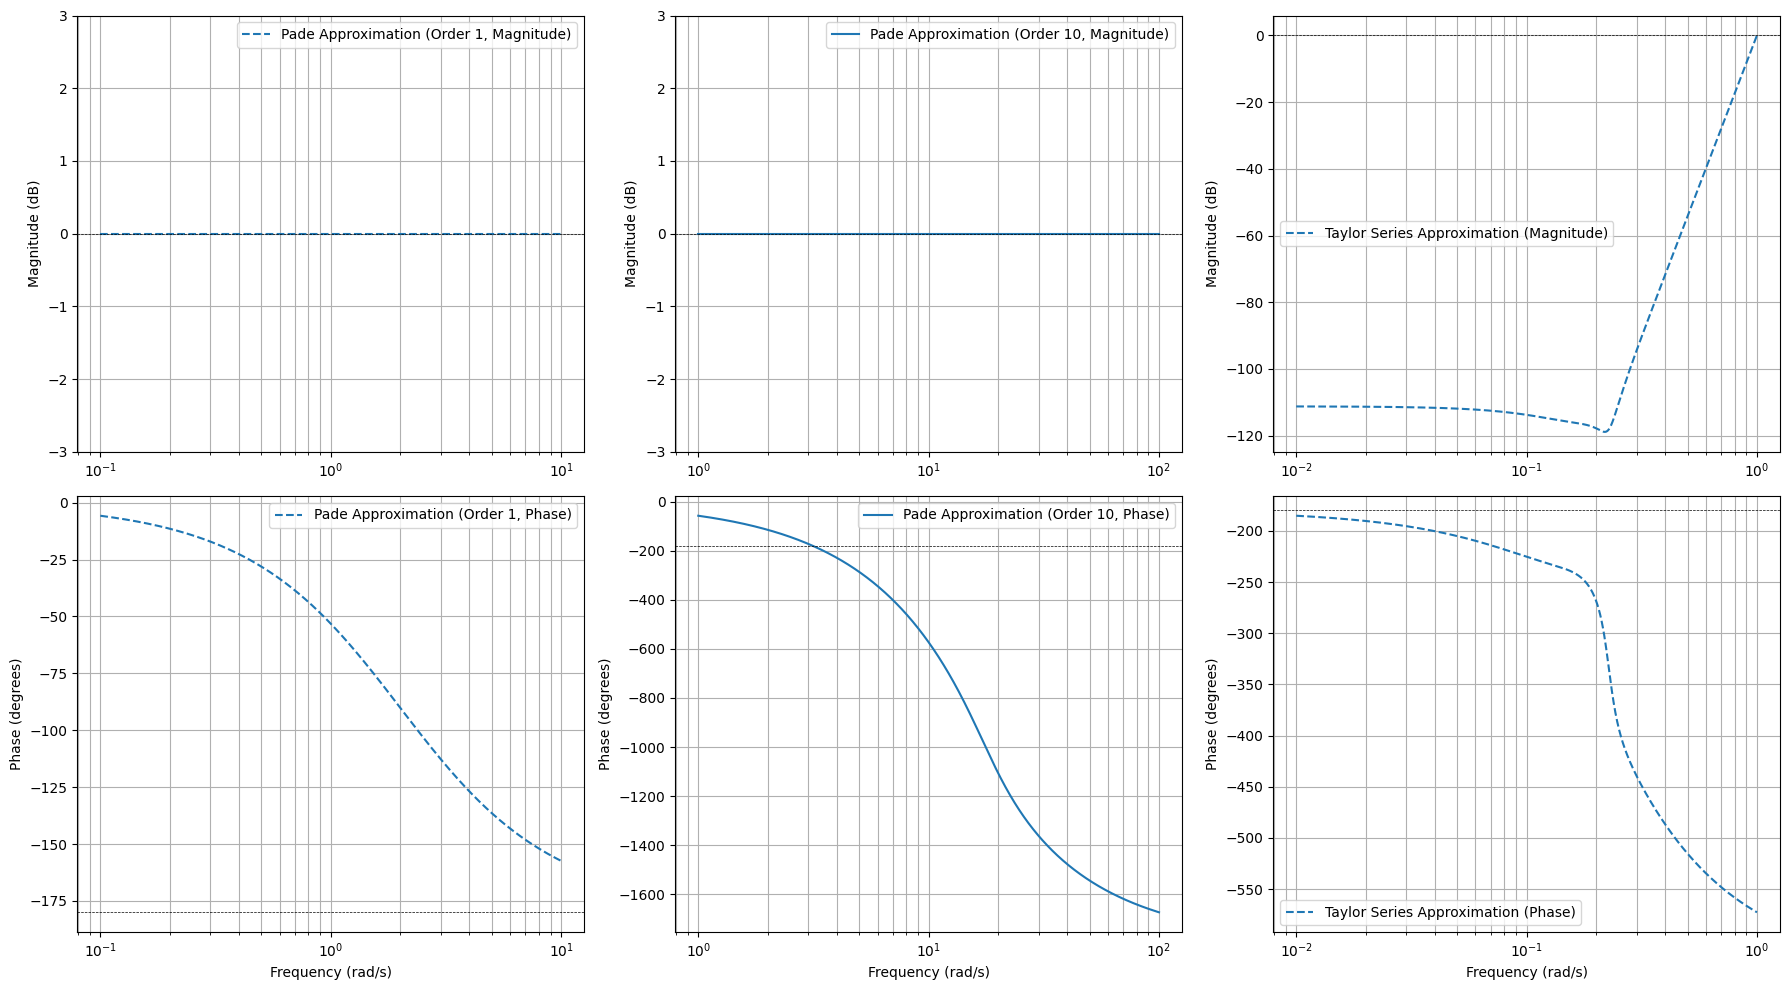

In [11]:
def bode_plot_with_taylor(T, degree, plt, ax2):
    # Taylor series approximation
    num_coeffs_taylor, den_coeffs_taylor = taylor_series_expansion(T, degree)
    delay_sys_taylor = ct.TransferFunction(num_coeffs_taylor, den_coeffs_taylor)

    mag_taylor, phase_taylor, omega_taylor = ct.bode_plot(delay_sys_taylor, dB=True, deg=True, plot=False)
    mag_taylor = 20 * np.log10(mag_taylor)
    phase_taylor = np.degrees(phase_taylor)

    plt.semilogx(omega_taylor, mag_taylor, label='Taylor Series Approximation (Magnitude)', linestyle='--')
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.set_ylabel('Magnitude (dB)')
    plt.legend(loc='best')
    plt.grid(True, which="both")

    ax2.semilogx(omega_taylor, phase_taylor, label='Taylor Series Approximation (Phase)', linestyle='--')
    ax2.axhline(-180, color='black', linewidth=0.5, linestyle='--')
    ax2.set_ylabel('Phase (degrees)')
    ax2.set_xlabel('Frequency (rad/s)')
    ax2.legend(loc='best')
    ax2.grid(True, which="both")

def taylor_series_expansion(T, degree):
    numerator_coeffs = []
    denominator_coeffs = [1]

    for n in range(degree):
        coeff = ((-1)**n * (T**n)) / math.factorial(n)
        numerator_coeffs.append(coeff)
    
    # flip the numerator coefficients to match the order of the transfer function
    numerator_coeffs = numerator_coeffs[::-1]
    return numerator_coeffs, denominator_coeffs

def bode_plot_with_pade(T, degree, plt, ax2):
    # Nth-order Pade approximation (user-selected degree)
    nth_order_num_pade, nth_order_den_pade = ct.pade(T, n=degree)
    nth_order_sys_pade = ct.TransferFunction(nth_order_num_pade, nth_order_den_pade)

    mag_nth, phase_nth, omega_nth = ct.bode_plot(nth_order_sys_pade, dB=True, deg=True, plot=False)
    mag_nth = 20 * np.log10(mag_nth)
    phase_nth = np.degrees(phase_nth)

    plt.semilogx(omega_nth, mag_nth, label=f'Pade Approximation (Order {degree}, Magnitude)', linestyle='-')
    plt.set_ylim(-3, 3)
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.set_ylabel('Magnitude (dB)')
    plt.legend(loc='best')
    plt.grid(True, which="both")

    ax2.semilogx(omega_nth, phase_nth, label=f'Pade Approximation (Order {degree}, Phase)', linestyle='-')
    ax2.axhline(-180, color='black', linewidth=0.5, linestyle='--')
    ax2.set_ylabel('Phase (degrees)')
    ax2.set_xlabel('Frequency (rad/s)')
    ax2.legend(loc='best')
    ax2.grid(True, which="both")

def bode_plot_first_order_pade(T, plt, ax2):
    # First-order Pade approximation
    first_order_num_pade, first_order_den_pade = ct.pade(T, n=1)
    first_order_sys_pade = ct.TransferFunction(first_order_num_pade, first_order_den_pade)

    mag_first, phase_first, omega_first = ct.bode_plot(first_order_sys_pade, dB=True, deg=True, plot=False)
    mag_first = 20 * np.log10(mag_first)
    phase_first = np.degrees(phase_first)

    plt.semilogx(omega_first, mag_first, label='Pade Approximation (Order 1, Magnitude)', linestyle='--')
    plt.set_ylim(-3, 3)
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.set_ylabel('Magnitude (dB)')
    plt.legend(loc='best')
    plt.grid(True, which="both")

    ax2.semilogx(omega_first, phase_first, label='Pade Approximation (Order 1, Phase)', linestyle='--')
    ax2.axhline(-180, color='black', linewidth=0.5, linestyle='--')
    ax2.set_ylabel('Phase (degrees)')
    ax2.set_xlabel('Frequency (rad/s)')
    ax2.legend(loc='best')
    ax2.grid(True, which="both")

def update_bode_plot(b):
    clear_output(wait=True)
    display(widgets.VBox([timedelay_slider, degree_slider_pade, degree_slider_taylor, plot_button]))

    try:
        T_pade = timedelay_slider.value
        degree_pade = int(degree_slider_pade.value)
        T_taylor = timedelay_slider.value
        degree_taylor = int(degree_slider_taylor.value)

        fig, axs = plt.subplots(2, 3, figsize=(18, 10))

        # First-order Pade approximation (Column 1)
        bode_plot_first_order_pade(T_pade, axs[0, 0], axs[1, 0])

        # Nth-order Pade approximation (Column 2)
        bode_plot_with_pade(T_pade, degree_pade, axs[0, 1], axs[1, 1])

        # Taylor series approximation (Column 3)
        bode_plot_with_taylor(T_taylor, degree_taylor, axs[0, 2], axs[1, 2])

        # Adjust layout for better readability
        plt.tight_layout()
        plt.show()

    except ValueError:
        print("Please enter valid coefficients separated by commas.")

timedelay_slider = widgets.FloatSlider(
    value=1.0,
    min=0.01,
    max=2.0,
    step=0.01,
    description='Time Delay (s):',
    continuous_update=False
)

degree_slider_pade = widgets.IntSlider(
    value=10,
    min=1,
    max=20,
    step=1,
    description='Pade Degree:'
)


degree_slider_taylor = widgets.IntSlider(
    value=10,
    min=1,
    max=20,
    step=1,
    description='Taylor Degree:'
)

plot_button = widgets.Button(description="Plot Bode")
plot_button.on_click(update_bode_plot)

# Display widgets for interaction
display(widgets.VBox([timedelay_slider, degree_slider_pade, degree_slider_taylor, plot_button]))


### Example



We want to use the root locus method to design a controller for our simple $\frac{1}{s+1}$ system, but we have a delay of 0.5 seconds inside our system. How do we approximate the time delay as a rational function which we can use for the root locus method?

First, we calculate the Padeé approximation using the formula we derived before:

$$e^{-0.5s} \approx \frac{1-0.25s}{1+0.25s}$$

Now we modify our plant transfer function to:
$$P(s) = \frac{1-0.25s}{1+0.25s} \cdot \frac{1}{s+1}$$

and use a proportional controller $C(s) = K_p$.

Since the transfer function of the Padeé approximation has a non-minimum phase zero, as we increase our gain, the system can become unstable. Note that this is an approximation.


In [29]:

def plot_root_locus(num, den, time_delay, pade_order):
    num = [float(n) for n in num.split(',')]
    den = [float(d) for d in den.split(',')]

    pade_order = int(pade_order)

    plant = ct.TransferFunction(num, den)

    pade_num, pade_den = ct.pade(time_delay, pade_order)

    pade_transfer_function = ct.TransferFunction(pade_num, pade_den)

    system_with_delay = plant * pade_transfer_function

    plt.figure()
    ct.root_locus_plot(system_with_delay, grid = False)
    plt.title(f"Root Locus with Time Delay {time_delay}s and Pade Order {pade_order}")
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True)
    plt.show()

time_delay_slider = FloatSlider(value=0.5, min=0, max=5, step=0.1, description='Time Delay (s):')
pade_order_slider = FloatSlider(value=1, min=1, max=10, step=1, description='Pade Approx Order:')

num_input = widgets.Text(value='1', description='Numerator:')
den_input = widgets.Text(value='1,1', description='Denominator:')

interactive_plot = interactive(plot_root_locus,
                               num=num_input,
                               den=den_input,
                               time_delay=time_delay_slider,
                               pade_order=pade_order_slider)

display(interactive_plot)


interactive(children=(Text(value='1', description='Numerator:'), Text(value='1,1', description='Denominator:')…

# 2. Cascaded Control: A Deeper Dive



Cascaded control is a hierarchical control strategy often used in complex systems to achieve better performance and robustness. Instead of using a single control loop to manage all dynamics, cascaded control divides the system into multiple interconnected control loops, typically organized as an **inner loop** and an **outer loop**. Each loop has its specific role, and they work together to maintain system stability and meet performance objectives. This structure allows engineers to address different dynamic behaviors in a controlled and systematic way.

In a cascaded control system, the **inner loop** is responsible for controlling faster dynamic processes that are closer to the physical system, such as stabilizing motor speed or force. The **outer loop** operates on slower dynamics and focuses on achieving broader system goals, such as maintaining a desired position or trajectory. This separation of tasks makes cascaded control particularly effective for systems where different parts have distinct time scales of operation. For example, in robotics, the inner loop might control motor torque, while the outer loop adjusts the robot's arm position based on a task requirement.



## 2.1 What is Cascaded Control?


At its core, cascaded control organizes control tasks into layers, with each layer addressing specific aspects of the system's dynamics. The inner loop works on stabilizing the plant and reacting to disturbances quickly. For instance, in a speed control system, the inner loop ensures that the motor achieves the desired speed regardless of load variations. The outer loop, on the other hand, determines the reference for the inner loop based on the higher-level goal, such as reaching a specific position or maintaining a desired spacing in adaptive cruise control.

One of the defining features of cascaded control is **feedback interconnection**. The outer loop provides a dynamic reference signal to the inner loop, and the inner loop refines its behavior to match this reference. This hierarchical feedback allows the outer loop to operate as if the inner loop is perfectly handling fast dynamics, simplifying its design and improving overall system performance.



## 2.2 How Does Cascaded Control Work?


Imagine you are driving a car equipped with adaptive cruise control (ACC). The system's goal is to maintain a safe distance from the car ahead while ensuring your car stays at a comfortable speed. This control problem is naturally divided into two tasks:

1. **Inner Loop (Speed Control):** The inner loop adjusts the car's throttle to maintain the desired speed. If the car encounters a hill or additional load, the inner loop quickly increases the throttle to compensate. This loop operates on fast dynamics and directly controls the engine's output.

2. **Outer Loop (Distance Control):** The outer loop monitors the distance to the car ahead and adjusts the speed reference for the inner loop to ensure safety. If the car ahead slows down, the outer loop instructs the inner loop to reduce speed accordingly. This loop handles slower dynamics and provides the overarching control objective.

This example highlights how cascaded control allows each loop to focus on specific tasks while working in harmony to achieve the overall goal. The inner loop acts as the "executor," rapidly handling disturbances and local dynamics, while the outer loop is the "strategist," setting the direction based on broader objectives.



## 2.3 Design Principles in Cascaded Control


The key to designing a successful cascaded control system lies in **bandwidth separation**. The inner loop must operate much faster than the outer loop, ensuring that it can stabilize fast dynamics before the outer loop intervenes. This separation prevents interference between the loops and allows the system to behave predictably. A general rule of thumb is that the bandwidth of the inner loop should be around ten times greater than the outer loop.

To illustrate this, consider a robotic arm with cascaded control. The inner loop might control the torque applied to the motor, ensuring rapid and precise adjustments to stabilize the arm. The outer loop, operating on a slower timescale, focuses on positioning the arm at a desired location. If the inner loop is slow, it might not stabilize the torque quickly enough, leading to delays and inaccuracies in the outer loop's positioning.

## 2.4 Advantages of Cascaded Control


Cascaded control offers several advantages that make it a popular choice in engineering systems. 

Firstly, it improves system performance by dividing responsibilities between the loops. Each loop is optimized for its specific task, allowing for more precise and efficient control. 

Secondly, cascaded control enhances the system's ability to reject disturbances. By having the inner loop directly manage disturbances near the plant, the system can remain stable even under challenging conditions. This layered approach simplifies the design of the outer loop, as it can assume the inner loop is handling these disturbances effectively.

Lastly, cascaded control provides a modular design approach. Engineers can design, test, and optimize each loop independently, reducing complexity and making it easier to maintain and upgrade the system. This modularity is especially valuable in systems with changing requirements, as individual loops can be adjusted without overhauling the entire control architecture.




## Summary of Cascaded Control



Cascaded control is an effective way to manage complex systems with multiple dynamic requirements. By separating the control problem into hierarchical loops, it allows each loop to focus on specific dynamics, leading to better performance and robustness. The inner loop addresses fast, local dynamics, while the outer loop ensures the system meets broader objectives. This structure is widely used in applications like robotics, automotive systems, and industrial processes.

In the accompanying interactive notebook, you’ll have the opportunity to design a cascaded control system for a sample plant. By adjusting controller gains and observing the system's response, you’ll gain a deeper understanding of how bandwidth separation and hierarchical feedback influence system performance.


In [13]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
from control import TransferFunction, feedback, step_response, impulse_response, forced_response, bode

import matplotlib.pyplot as plt

# Define helper functions
def create_pid_controller(kp, ki, kd):
    """Create a PID controller transfer function."""
    num = [kd, kp, ki]
    den = [1, 0]
    return TransferFunction(num, den)

def parse_transfer_function(num_str, den_str):
    """Parse numerator and denominator strings into TransferFunction."""
    try:
        num = [float(x.strip()) for x in num_str.split(',')]
        den = [float(x.strip()) for x in den_str.split(',')]
        return TransferFunction(num, den)
    except Exception as e:
        raise ValueError("Invalid input. Please provide comma-separated numbers.")

def plot_response(system, response_type, duration=10):
    """Plot the system response (step, impulse, or ramp)."""
    time = np.linspace(0, duration, 500)
    if response_type == 'Step':
        t, y = step_response(system, time)
    elif response_type == 'Impulse':
        t, y = impulse_response(system, time)
    elif response_type == 'Ramp':
        ramp_input = time
        t, y, _ = forced_response(system, time, ramp_input)
    else:
        raise ValueError("Unsupported response type.")

    plt.figure(figsize=(8, 5))
    plt.plot(t, y, label=f"{response_type} Response")
    plt.xlabel("Time (s)")
    plt.ylabel("Output")
    plt.title(f"{response_type} Response")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_bode(system):
    """Plot the Bode plot of the system."""
    mag, phase, omega = bode(system, dB=True, plot=False)

    plt.figure(figsize=(8, 5))
    plt.semilogx(omega, 20 * np.log10(mag), label="Magnitude (dB)")
    plt.xlabel("Frequency (rad/s)")
    plt.ylabel("Magnitude (dB)")
    plt.title("Bode Plot: Magnitude")
    plt.grid(True, which="both")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.semilogx(omega, phase * 180 / np.pi, label="Phase (deg)")
    plt.xlabel("Frequency (rad/s)")
    plt.ylabel("Phase (degrees)")
    plt.title("Bode Plot: Phase")
    plt.grid(True, which="both")
    plt.legend()
    plt.show()

# Interactive tool widgets
numerator_input = widgets.Text(
    value='1',
    placeholder='e.g., 1, 5, 10',
    description='Numerator:',
    style={'description_width': 'initial'}
)

denominator_input = widgets.Text(
    value='1,2',
    placeholder='e.g., 1, 3, 2',
    description='Denominator:',
    style={'description_width': 'initial'}
)

kp_outer = widgets.FloatSlider(value=1.0, min=0.0, max=10.0, step=0.1, description='Outer Kp:')
ki_outer = widgets.FloatSlider(value=0.0, min=0.0, max=10.0, step=0.1, description='Outer Ki:')
kd_outer = widgets.FloatSlider(value=0.0, min=0.0, max=10.0, step=0.1, description='Outer Kd:')

kp_inner = widgets.FloatSlider(value=1.0, min=0.0, max=10.0, step=0.1, description='Inner Kp:')
ki_inner = widgets.FloatSlider(value=0.0, min=0.0, max=10.0, step=0.1, description='Inner Ki:')
kd_inner = widgets.FloatSlider(value=0.0, min=0.0, max=10.0, step=0.1, description='Inner Kd:')

response_type = widgets.Dropdown(
    options=['Step', 'Impulse', 'Ramp'],
    value='Step',
    description='Response Type:',
    style={'description_width': 'initial'}
)

duration_input = widgets.FloatText(value=10.0, description='Duration (s):')

bode_plot_button = widgets.Checkbox(
    value=True,
    description='Show Bode Plot',
    style={'description_width': 'initial'}
)

output_area = widgets.Output()

# Simulation handler
def update_plot(change):
    with output_area:
        clear_output(wait=True)
        try:
            # Parse plant transfer function
            plant = parse_transfer_function(numerator_input.value, denominator_input.value)

            # Create PID controllers
            outer_pid = create_pid_controller(kp_outer.value, ki_outer.value, kd_outer.value)
            inner_pid = create_pid_controller(kp_inner.value, ki_inner.value, kd_inner.value)

            # Inner loop
            inner_loop = feedback(inner_pid * plant, 1)

            # Outer loop
            cascaded_system = feedback(outer_pid * inner_loop, 1)

            # Plot chosen response
            plot_response(cascaded_system, response_type.value, duration=duration_input.value)

            # Optionally show Bode plot
            if bode_plot_button.value:
                plot_bode(cascaded_system)

        except ValueError as ve:
            print(f"Error: {ve}")
        except Exception as e:
            print(f"Unexpected error: {e}")

# Attach update function to sliders
kp_outer.observe(update_plot, names='value')
ki_outer.observe(update_plot, names='value')
kd_outer.observe(update_plot, names='value')
kp_inner.observe(update_plot, names='value')
ki_inner.observe(update_plot, names='value')
kd_inner.observe(update_plot, names='value')
response_type.observe(update_plot, names='value')
duration_input.observe(update_plot, names='value')
bode_plot_button.observe(update_plot, names='value')

# Display widgets
display(widgets.VBox([
    widgets.Label(value="Cascaded Control System with PID Controllers"),
    numerator_input,
    denominator_input,
    widgets.Label(value="Outer Loop PID Controller Parameters"),
    kp_outer, ki_outer, kd_outer,
    widgets.Label(value="Inner Loop PID Controller Parameters"),
    kp_inner, ki_inner, kd_inner,
    response_type, duration_input, bode_plot_button,
    output_area
]))

# Initial plot
update_plot(None)